# Trainable MNIST

Raytune has a great collection of [examples](https://github.com/ray-project/ray/tree/master/python/ray/tune/examples) and I have picked a simple one to impement in a notebook. This is godo to play with if you are within a GPU or want to try a *big* parameter search as it's relatively quick and easy to train.


## What is MNIST?

In case you are unfamilar MNIST is a standard handwritten character dataset used widely in Machine Learning examples. The dataset consists of 70,000 28x28 images (60,000 training and 10,000 test)


Here are some examples from the dataset [source: wikipedia](https://en.wikipedia.org/wiki/MNIST_database#/media/File:MnistExamples.png)

![MNIST Examples](MnistExamples.png)



### Load Dependencies

We load the usual deps and also load [PyTorch](https://pytorch.org/docs/stable/index.html) so that we can define a small Neural Network to train as a classifer

In [ ]:
%load_ext autoreload
%autoreload 2

from dependencies import *

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Dataloaders

We'll re-use some standard dataloaders from the ray examples. This function returns 2 pytorch dataloaders, one for train and one for test

In [3]:
from mnist_pytorch import get_data_loaders

## Network

We define a very small ConvNET with a single Conv2D layer and single Linear Layer

Things to Try:
 - Try building up larger networks to see if performance improves
 - Try adding options to the `__init__()` function to vary layer properties or the number of layers and tune these new parameters

In [4]:
class ConvNet(nn.Module):
    def __init__(self, width=3):
        super(ConvNet, self).__init__()       
        self.width=width
        
        self.conv1 = nn.Conv2d(1, width, kernel_size=3)
        self.fc = nn.Linear(width*8*8, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.width*8*8) # flattens the tensor for the FC layer
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

## Train & Test Functions

We define some functions for out training and testing loops

During training, we iterate over examples while calculating losses, backpropagating and optimising the network

In [6]:
EPOCH_SIZE = 512

def train(model, optimizer, train_loader, device=None):
    device = device or torch.device("cpu")
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

During test time we iterate over the test set and calculate performance metrics

In [7]:
TEST_SIZE=256

def test(model, data_loader, device=None):
    device = device or torch.device("cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

## Check for CUDA

In [8]:
print('CUDA Available :D') if torch.cuda.is_available() else print('CPU Only :O')

CUDA Available :D


## Start Ray

In [9]:
ray.shutdown()
ray.init(num_cpus=10, num_gpus=0)

2020-11-10 16:32:49,758	INFO services.py:1164 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.123.68',
 'raylet_ip_address': '192.168.123.68',
 'redis_address': '192.168.123.68:6379',
 'object_store_address': '/tmp/ray/session_2020-11-10_16-32-49_098191_7629/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-11-10_16-32-49_098191_7629/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-11-10_16-32-49_098191_7629',
 'metrics_export_port': 48294}

In [11]:
from os import path

class TrainMNIST(tune.Trainable):

    # with config, pass in hyperparameters for net + optimizer
    def _setup(self, config):
        # detect if cuda is availalbe as ray will assign GPUs if available and configured
        self.device = torch.device("cpu")

        # In this case this will also fetch the MNIST data on first run
        #
        self.train_loader, self.test_loader = get_data_loaders()
        
        # create an instance of the network and pass it to device
        self.model = ConvNet(
            # pass in parameters here if we want to tune network internals
        ).to(self.device)
        
        #setup the optimiser (try Adam instead and change parameters we are tuning)
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=config.get("lr", 0.01),
            momentum=config.get("momentum", 0.9))
                
    # if applicable, pass batch size and epochs
    def _train(self):
        
        train(self.model, self.optimizer, self.train_loader, device=self.device)
        
        acc = test(self.model, self.test_loader, self.device)
        
        return {"mean_accuracy": acc}
    
    
    def _save(self, checkpoint_dir):
        checkpoint_path = path.join(checkpoint_dir, "model.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        return checkpoint_path
    
    
    def _restore(self, checkpoint_path):
        self.model.load_state_dict(torch.load(checkpoint_path))

In [12]:
config = {
        "lr": tune.uniform(0.001, 0.1),
        "momentum": tune.uniform(0.1, 0.9),
    }


analysis = tune.run(
    TrainMNIST,
    config=config,
    local_dir="~/ray_results/torch_mnist",
    mode='max',
    resources_per_trial={
        "cpu": 2,
        "gpu": 0
    },
    num_samples=3,
    checkpoint_at_end=True,
    checkpoint_freq=10,
#     keep_checkpoints_num=3, # only keep n best checkpoints
    stop={
        "mean_accuracy": 0.99,
        "training_iteration": 100,
    })



Trial name,status,loc,lr,momentum
TrainMNIST_7f89a_00000,RUNNING,,0.0314558,0.891798
TrainMNIST_7f89a_00001,PENDING,,0.0938618,0.652903
TrainMNIST_7f89a_00002,PENDING,,0.0353234,0.283825


(pid=7989) 2020-11-10 16:36:29,393	WARNING trainable.py:860 -- Trainable._setup is deprecated and will be removed in a future version of Ray. Override Trainable.setup instead.
(pid=7994) 2020-11-10 16:36:29,418	WARNING trainable.py:860 -- Trainable._setup is deprecated and will be removed in a future version of Ray. Override Trainable.setup instead.
(pid=7992) 2020-11-10 16:36:29,466	WARNING trainable.py:860 -- Trainable._setup is deprecated and will be removed in a future version of Ray. Override Trainable.setup instead.
(pid=7989) 2020-11-10 16:36:29,902	WARNING trainable.py:728 -- Trainable._train is deprecated and will be removed in a future version of Ray. Override Trainable.step instead.
(pid=7994) 2020-11-10 16:36:29,886	WARNING trainable.py:728 -- Trainable._train is deprecated and will be removed in a future version of Ray. Override Trainable.step instead.
(pid=7992) 2020-11-10 16:36:29,898	WARNING trainable.py:728 -- Trainable._train is deprecated and will be removed in a fut

Result for TrainMNIST_7f89a_00000:
  date: 2020-11-10_16-36-29
  done: false
  experiment_id: 36c84d11c60c4b8b8bcf351f66a3c684
  experiment_tag: 0_lr=0.031456,momentum=0.8918
  hostname: Schlepptop
  iterations_since_restore: 1
  mean_accuracy: 0.4875
  node_ip: 192.168.123.68
  pid: 7994
  time_since_restore: 0.4162588119506836
  time_this_iter_s: 0.4162588119506836
  time_total_s: 0.4162588119506836
  timestamp: 1605022589
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7f89a_00000
  
Result for TrainMNIST_7f89a_00001:
  date: 2020-11-10_16-36-29
  done: false
  experiment_id: b772fb74b1e5461b961b4e90c63f58aa
  experiment_tag: 1_lr=0.093862,momentum=0.6529
  hostname: Schlepptop
  iterations_since_restore: 1
  mean_accuracy: 0.665625
  node_ip: 192.168.123.68
  pid: 7992
  time_since_restore: 0.42832469940185547
  time_this_iter_s: 0.42832469940185547
  time_total_s: 0.42832469940185547
  timestamp: 1605022589
  timesteps_since_restore: 0
  training_iteration: 1
  tr

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_7f89a_00000,RUNNING,192.168.123.68:7994,0.0314558,0.891798,0.928125,11,3.50817
TrainMNIST_7f89a_00001,RUNNING,192.168.123.68:7992,0.0938618,0.652903,0.8875,10,3.3598
TrainMNIST_7f89a_00002,RUNNING,192.168.123.68:7989,0.0353234,0.283825,0.86875,10,3.27625


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_7f89a_00000,RUNNING,192.168.123.68:7994,0.0314558,0.891798,0.95625,26,8.4144
TrainMNIST_7f89a_00001,RUNNING,192.168.123.68:7992,0.0938618,0.652903,0.953125,24,8.10746
TrainMNIST_7f89a_00002,RUNNING,192.168.123.68:7989,0.0353234,0.283825,0.878125,25,8.46382


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_7f89a_00000,RUNNING,192.168.123.68:7994,0.0314558,0.891798,0.94375,42,13.3247
TrainMNIST_7f89a_00001,RUNNING,192.168.123.68:7992,0.0938618,0.652903,0.9625,40,13.1684
TrainMNIST_7f89a_00002,RUNNING,192.168.123.68:7989,0.0353234,0.283825,0.890625,41,13.4389


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_7f89a_00000,RUNNING,192.168.123.68:7994,0.0314558,0.891798,0.928125,58,18.4538
TrainMNIST_7f89a_00001,RUNNING,192.168.123.68:7992,0.0938618,0.652903,0.946875,56,18.3573
TrainMNIST_7f89a_00002,RUNNING,192.168.123.68:7989,0.0353234,0.283825,0.896875,57,18.2515


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_7f89a_00000,RUNNING,192.168.123.68:7994,0.0314558,0.891798,0.94375,72,23.2255
TrainMNIST_7f89a_00001,RUNNING,192.168.123.68:7992,0.0938618,0.652903,0.95,71,23.2431
TrainMNIST_7f89a_00002,RUNNING,192.168.123.68:7989,0.0353234,0.283825,0.915625,75,23.4894


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_7f89a_00000,RUNNING,192.168.123.68:7994,0.0314558,0.891798,0.946875,88,28.4589
TrainMNIST_7f89a_00001,RUNNING,192.168.123.68:7992,0.0938618,0.652903,0.940625,87,28.3333
TrainMNIST_7f89a_00002,RUNNING,192.168.123.68:7989,0.0353234,0.283825,0.928125,91,28.2679


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_7f89a_00000,TERMINATED,,0.0314558,0.891798,0.925,100,32.3064
TrainMNIST_7f89a_00001,TERMINATED,,0.0938618,0.652903,0.946875,100,32.4126
TrainMNIST_7f89a_00002,TERMINATED,,0.0353234,0.283825,0.925,100,30.8943


In [18]:
from pprint import pprint
print("Best config is:")
pprint(analysis.get_best_trial(metric="mean_accuracy"))
pprint(analysis.get_best_config(metric="mean_accuracy"))

Best config is:
TrainMNIST_7f89a_00001
{'lr': 0.0938618490320079, 'momentum': 0.6529032733476126}


In [14]:
%load_ext tensorboard
from tensorboard import notebook
%tensorboard --logdir "~/ray_results/torch_mnist"

Launching TensorBoard...

## Load a model and check results

In [20]:
train_loader, test_loader = get_data_loaders()

In [21]:
X, y = list(test_loader)[np.random.randint(0, len(test_loader))]

#### Find the model checkpoint you want to load

In [23]:
# select model with highest accuracy according to tensorboard
# TrainMNIST_f5e1d_00000_0_lr=0.061562,momentum=0.72127_2020-11-09_17-45-23
# (weirdly it's not the same as best_config

# create path to model file
checkpoint_path = path.join(path.expanduser('~'),'ray_results','torch_mnist','TrainMNIST',
                          'TrainMNIST_f5e1d_00000_0_lr=0.061562,momentum=0.72127_2020-11-09_17-45-23',
                         'checkpoint_100', 'model.pth')
print(path.exists(checkpoint_path))
print(checkpoint_path)

True
/home/lena/ray_results/torch_mnist/TrainMNIST/TrainMNIST_f5e1d_00000_0_lr=0.061562,momentum=0.72127_2020-11-09_17-45-23/checkpoint_100/model.pth


In [26]:
device = torch.device("cpu")

with torch.set_grad_enabled(False):
    model = ConvNet()
    model.load_state_dict(torch.load(checkpoint_path))
    
    model.to(device)
    
    y_ = model(X.to(device)).cpu()
    
    _, predicted = torch.max(y_, 1)

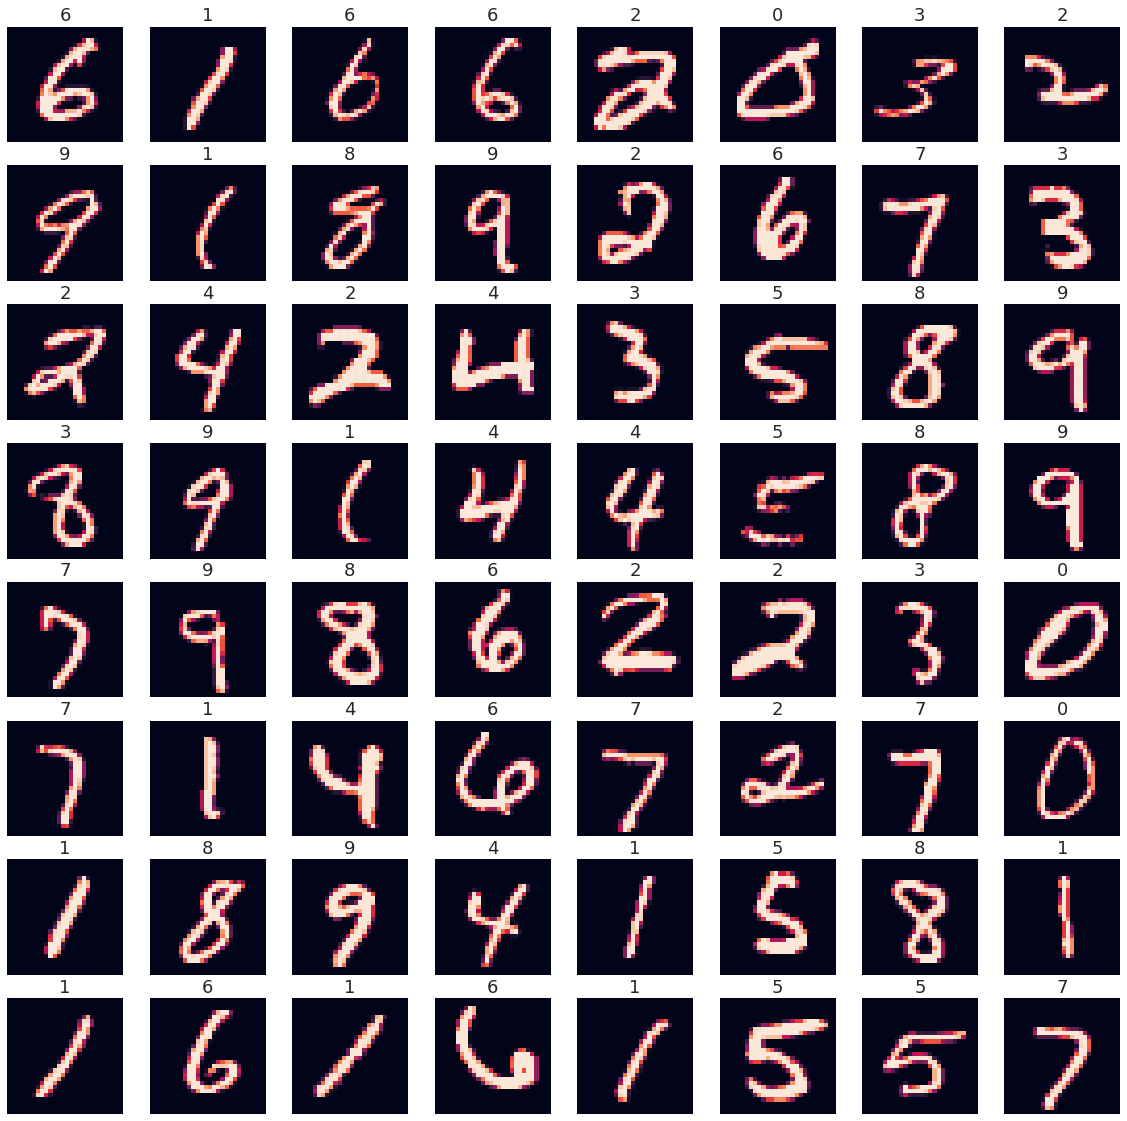

In [27]:
fig, axs = plt.subplots(8,8, figsize=(20,20))
axsf = [item for s in axs for item in s]

for n,ax in enumerate(axsf):
    ax.imshow(X[n].squeeze().numpy())
    ax.axis('off')
    ax.set_title(predicted[n].item())
    
plt.show()

In [28]:
ray.shutdown()


In [ ]:
# https://github.com/ray-project/ray/issues/4569

In [ ]:
# Exercises
# - change out the optimiser for adam
# - add network hyperparameters